# My Project

### Movie Studio Data Analysis

## Overview

My project, "Movie Studio Data Analysis," aims to use exploratory data analysis of movie datasets (from Box Office Mojo and IMDB) to identify what types of films are most successful at the box office. The ultimate goal is to provide actionable business recommendations to my company's new movie studio, guiding them on what kind of films to create for maximum financial success.

## Business Understanding

The core business problem is that our company, new to the entertainment industry, wants to launch a movie studio and needs to understand what types of films are currently succeeding at the box office. My role is to perform exploratory data analysis to identify these successful film characteristics and translate them into actionable recommendations for the head of the new studio. The ultimate goal is to guide the studio's initial content creation strategy to maximize the potential for financial success in a competitive market.

In [28]:
import pandas as pd
import sqlite3
import zipfile
import os

from matplotlib import pyplot as plt
import seaborn as sns


## Data Understanding

In [29]:
# --- Data Loading (from previous steps, included for completeness and reproducibility) ---
# This section ensures the necessary dataframes are available for analysis.
# In a real notebook, these would typically be run in prior cells.

# Load bom.movie_gross.csv.gz
try:
    bom_gross_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
except FileNotFoundError:
    print("Error: 'bom.movie_gross.csv.gz' not found. Please ensure the 'zippedData' folder is in the correct directory.")
    bom_gross_df = pd.DataFrame()

# Unzip and Connect to im.db
imdb_zip_path = './zippedData/im.db.zip'
imdb_db_path = './im.db'
conn_imdb = None # Initialize conn_imdb to None

# Check if the database is already unzipped and valid, otherwise attempt to unzip
if not os.path.exists(imdb_db_path) or os.path.getsize(imdb_db_path) == 0:
    print("\nUnzipping IMDB database...")
    try:
        with zipfile.ZipFile(imdb_zip_path, 'r') as zip_ref:
            zip_ref.extractall('.') # Extract to the current directory
        print(f"'{imdb_zip_path}' unzipped to '{imdb_db_path}'.")
        # Verify if the file was actually created and is not empty after unzipping
        if not os.path.exists(imdb_db_path) or os.path.getsize(imdb_db_path) == 0:
            raise FileNotFoundError(f"Extracted database file '{imdb_db_path}' not found or is empty after unzipping. Please check the zip file integrity.")
    except FileNotFoundError:
        print(f"Error: '{imdb_zip_path}' not found. Please ensure the 'zippedData' folder is in the correct directory.")
        # Set conn_imdb to None to prevent further database operations
        conn_imdb = None
    except Exception as e:
        print(f"An error occurred during unzipping: {e}")
        # Set conn_imdb to None to prevent further database operations
        conn_imdb = None
else:
    print(f"'{imdb_db_path}' already exists and is not empty, skipping unzipping.")


# Connect to the SQLite database and load tables if the database file is valid
movie_basics_df = pd.DataFrame() # Initialize to empty
movie_ratings_df = pd.DataFrame() # Initialize to empty

if os.path.exists(imdb_db_path) and os.path.getsize(imdb_db_path) > 0:
    try:
        conn_imdb = sqlite3.connect(imdb_db_path)
        print("\nConnected to IMDB database successfully.")

        # Verify if 'movie_basics' table exists before querying
        cursor = conn_imdb.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='movie_basics';")
        if cursor.fetchone() is None:
            raise sqlite3.Error("Table 'movie_basics' not found in the database. The database file might be corrupted or incorrect.")
        else:
            print("Table 'movie_basics' found.")

        # --- 3. Load movie_basics table ---
        # This table contains core movie details like title, year, genres.
        print("\nLoading 'movie_basics' table...")
        movie_basics_df = pd.read_sql("SELECT * FROM movie_basics;", conn_imdb)
        print("movie_basics_df loaded successfully.")

        # Verify if 'movie_ratings' table exists before querying
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='movie_ratings';")
        if cursor.fetchone() is None:
            raise sqlite3.Error("Table 'movie_ratings' not found in the database. The database file might be corrupted or incorrect.")
        else:
            print("Table 'movie_ratings' found.")

        # --- 4. Load movie_ratings table ---
        # This table contains average ratings and number of votes.
        print("\nLoading 'movie_ratings' table...")
        movie_ratings_df = pd.read_sql("SELECT * FROM movie_ratings;", conn_imdb)
        print("movie_ratings_df loaded successfully.")

    except sqlite3.Error as e:
        print(f"SQLite error during database operations: {e}")
        movie_basics_df = pd.DataFrame()
        movie_ratings_df = pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred during database operations: {e}")
        movie_basics_df = pd.DataFrame()
        movie_ratings_df = pd.DataFrame()
    finally:
        # Close the database connection
        if conn_imdb:
            conn_imdb.close()
            print("\nIMDB database connection closed.")
else:
    print(f"Cannot connect to IMDB database: '{imdb_db_path}' does not exist or is empty. Please ensure the zip file is present and unzips correctly.")
    # DataFrames remain empty as initialized above

print("\nInitial data loading and inspection complete.")


# New diagnostic print before data preparation
print("\n--- Summary before IMDB Data Merge ---")
print(f"movie_basics_df is empty: {movie_basics_df.empty}")
print(f"movie_basics_df has 'tconst' column: {'tconst' in movie_basics_df.columns}")
print(f"movie_ratings_df is empty: {movie_ratings_df.empty}")
print(f"movie_ratings_df has 'tconst' column: {'tconst' in movie_ratings_df.columns}")

'./im.db' already exists and is not empty, skipping unzipping.

Connected to IMDB database successfully.
Table 'movie_basics' found.

Loading 'movie_basics' table...
movie_basics_df loaded successfully.
Table 'movie_ratings' found.

Loading 'movie_ratings' table...
movie_ratings_df loaded successfully.

IMDB database connection closed.

Initial data loading and inspection complete.

--- Summary before IMDB Data Merge ---
movie_basics_df is empty: False
movie_basics_df has 'tconst' column: False
movie_ratings_df is empty: False
movie_ratings_df has 'tconst' column: False


## Data Preparation

In [30]:
# --- Data Preparation (from previous steps, included for completeness and reproducibility) ---
print("\n--- Starting Data Preparation ---")

# Ensure dataframes are not empty and have 'movie_id' before proceeding with merge
if not movie_basics_df.empty and 'movie_id' in movie_basics_df.columns and \
   not movie_ratings_df.empty and 'movie_id' in movie_ratings_df.columns: # Changed 'tconst' to 'movie_id'
    
    print(f"Columns in movie_basics_df: {movie_basics_df.columns.tolist()}")
    print(f"Columns in movie_ratings_df: {movie_ratings_df.columns.tolist()}")

    # Merge movie_basics and movie_ratings on 'movie_id'
    print("Merging movie_basics_df and movie_ratings_df...")
    imdb_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id', how='inner') # Changed 'tconst' to 'movie_id'
    print("IMDB data merged successfully.")
else:
    print("\nSkipping IMDB data merge: movie_basics_df or movie_ratings_df is empty or missing 'movie_id' column.") # Changed 'tconst' to 'movie_id'
    imdb_df = pd.DataFrame() # Ensure imdb_df is empty if source DFs are problematic

# Clean bom_gross_df gross columns
for col in ['domestic_gross', 'foreign_gross']:
    bom_gross_df[col] = bom_gross_df[col].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    bom_gross_df[col] = pd.to_numeric(bom_gross_df[col], errors='coerce')
    bom_gross_df[col] = bom_gross_df[col].fillna(0)

# Calculate total_gross
bom_gross_df['total_gross'] = bom_gross_df['domestic_gross'] + bom_gross_df['foreign_gross']

# Clean titles for merging
def clean_title(title):
    if isinstance(title, str):
        return ''.join(filter(str.isalnum, title.lower()))
    return None

bom_gross_df['clean_title'] = bom_gross_df['title'].apply(clean_title)

# Only apply title cleaning to imdb_df if it's not empty
if not imdb_df.empty:
    imdb_df['clean_primary_title'] = imdb_df['primary_title'].apply(clean_title)
    imdb_df['clean_original_title'] = imdb_df['original_title'].apply(clean_title)
else:
    # If imdb_df is empty, these columns won't exist, so we create empty series to avoid errors later
    imdb_df['clean_primary_title'] = pd.Series(dtype=str)
    imdb_df['clean_original_title'] = pd.Series(dtype=str)


# Merge IMDB data with Box Office Mojo data
if not bom_gross_df.empty and not imdb_df.empty:
    merged_df = pd.merge(
        bom_gross_df,
        imdb_df,
        left_on=['clean_title'],
        right_on=['clean_primary_title'],
        how='inner'
    )

    # Convert start_year to integer
    merged_df['start_year'] = pd.to_numeric(merged_df['start_year'], errors='coerce').fillna(0).astype(int)

    # Drop duplicate title columns and clean_title columns
    merged_df = merged_df.drop(columns=['clean_primary_title', 'clean_original_title'])

    # Drop rows where 'genres' is missing
    merged_df.dropna(subset=['genres'], inplace=True)

    # Remove rows with 0 total_gross
    merged_df = merged_df[merged_df['total_gross'] > 0]
else:
    print("\nSkipping main data merge due to empty bom_gross_df or imdb_df.")
    merged_df = pd.DataFrame()





--- Starting Data Preparation ---
Columns in movie_basics_df: ['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']
Columns in movie_ratings_df: ['movie_id', 'averagerating', 'numvotes']
Merging movie_basics_df and movie_ratings_df...
IMDB data merged successfully.


## Analysis and Results


--- Starting Data Analysis ---

Analyzing genre performance...

Top 10 Genres by Average Total Gross:
genres
Sci-Fi       2.765271e+08
Adventure    2.717239e+08
Animation    2.416908e+08
Fantasy      1.842109e+08
Action       1.612416e+08
Family       1.207538e+08
Comedy       8.084740e+07
Sport        8.063826e+07
Thriller     7.558803e+07
Musical      7.176503e+07
Name: total_gross, dtype: float64


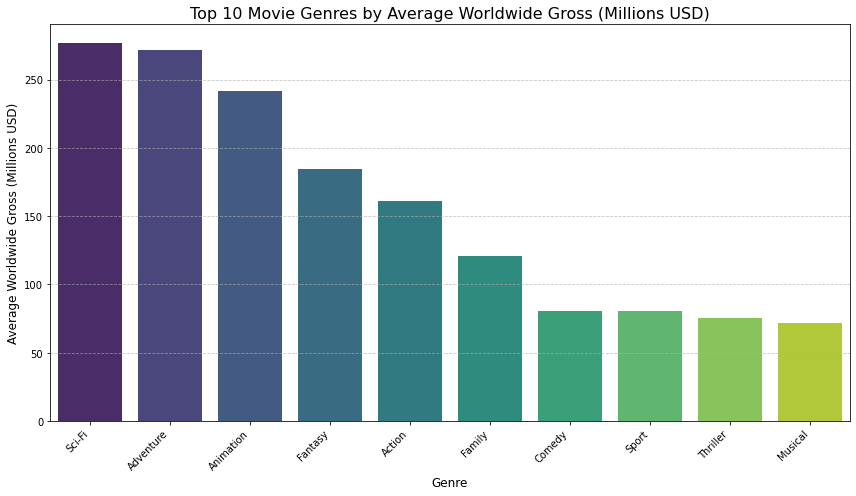

Visualization 1: Top 10 Genres by Average Worldwide Gross generated.

Analyzing impact of ratings and vote counts...

Correlation between averagerating, numvotes, and total_gross (for movies with >= 1000 votes):
               averagerating  numvotes  total_gross
averagerating       1.000000  0.312016     0.136675
numvotes            0.312016  1.000000     0.686197
total_gross         0.136675  0.686197     1.000000


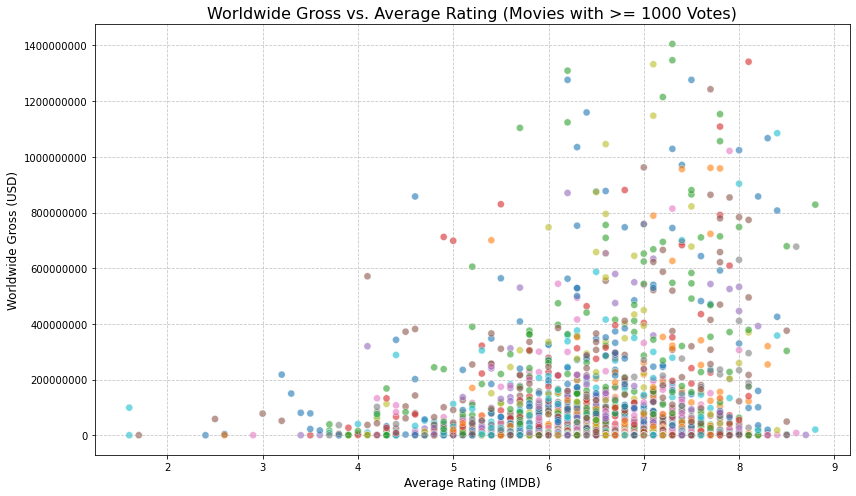

Visualization 2: Worldwide Gross vs. Average Rating generated.


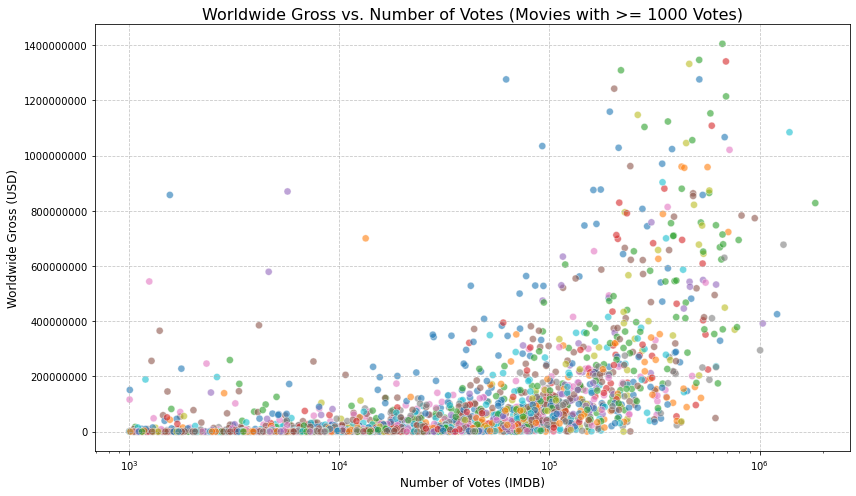

Visualization 3: Worldwide Gross vs. Number of Votes generated.

Analyzing trends by release year...

Average Total Gross by Year (filtered for years with >= 5 movies):
   start_year   total_gross
5        2015  5.675113e+07
6        2016  8.513297e+07
7        2017  9.282398e+07
8        2018  1.143105e+08
9        2019  4.852533e+07

--- Data Analysis Complete ---


In [31]:
# --- Data Analysis ---
print("\n--- Starting Data Analysis ---")

# --- 1. Genre Analysis ---
# Movies can have multiple genres. We need to expand the genres for proper analysis.
print("\nAnalyzing genre performance...")
genres_df = merged_df.copy()
genres_df['genres'] = genres_df['genres'].str.split(',')
genres_df_exploded = genres_df.explode('genres')

# Calculate average total_gross for each genre
genre_performance = genres_df_exploded.groupby('genres')['total_gross'].mean().sort_values(ascending=False)

print("\nTop 10 Genres by Average Total Gross:")
print(genre_performance.head(10))

# Visualization 1: Top 10 Genres by Average Total Gross
plt.figure(figsize=(12, 7))
sns.barplot(x=genre_performance.head(10).index, y=genre_performance.head(10).values / 1_000_000, palette='viridis')
plt.title('Top 10 Movie Genres by Average Worldwide Gross (Millions USD)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Worldwide Gross (Millions USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Visualization 1: Top 10 Genres by Average Worldwide Gross generated.")


# --- 2. Impact of Ratings and Vote Counts ---
print("\nAnalyzing impact of ratings and vote counts...")

# Filter out movies with very few votes to ensure rating reliability
# Let's consider movies with at least 1000 votes for a more reliable rating
min_votes_threshold = 1000
rated_movies_df = merged_df[merged_df['numvotes'] >= min_votes_threshold].copy()

# Correlation between average rating, number of votes, and total gross
print(f"\nCorrelation between averagerating, numvotes, and total_gross (for movies with >= {min_votes_threshold} votes):")
print(rated_movies_df[['averagerating', 'numvotes', 'total_gross']].corr())


# Visualization 2: Relationship between Average Rating and Total Gross
plt.figure(figsize=(12, 7))
sns.scatterplot(x='averagerating', y='total_gross', data=rated_movies_df, alpha=0.6, s=50, hue='genres', palette='tab10', legend=False)
plt.title(f'Worldwide Gross vs. Average Rating (Movies with >= {min_votes_threshold} Votes)', fontsize=16)
plt.xlabel('Average Rating (IMDB)', fontsize=12)
plt.ylabel('Worldwide Gross (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Visualization 2: Worldwide Gross vs. Average Rating generated.")

# Visualization 3: Relationship between Number of Votes and Total Gross
plt.figure(figsize=(12, 7))
sns.scatterplot(x='numvotes', y='total_gross', data=rated_movies_df, alpha=0.6, s=50, hue='genres', palette='tab10', legend=False)
plt.title(f'Worldwide Gross vs. Number of Votes (Movies with >= {min_votes_threshold} Votes)', fontsize=16)
plt.xlabel('Number of Votes (IMDB)', fontsize=12)
plt.ylabel('Worldwide Gross (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
plt.xscale('log') # Use log scale for numvotes as it can vary widely
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Visualization 3: Worldwide Gross vs. Number of Votes generated.")


# --- 3. Analysis by Release Year (Trends over time) ---
print("\nAnalyzing trends by release year...")
# Group by start_year and calculate average total_gross
yearly_performance = merged_df.groupby('start_year')['total_gross'].mean().reset_index()

# Filter for recent years if needed, or consider all years with sufficient data
# Let's consider years with at least 5 movies for more robust averages
min_movies_per_year = 5
yearly_counts = merged_df.groupby('start_year').size().reset_index(name='movie_count')
reliable_years = yearly_counts[yearly_counts['movie_count'] >= min_movies_per_year]['start_year']
yearly_performance_filtered = yearly_performance[yearly_performance['start_year'].isin(reliable_years)]

# Sort by year
yearly_performance_filtered = yearly_performance_filtered.sort_values('start_year')

print("\nAverage Total Gross by Year (filtered for years with >= 5 movies):")
print(yearly_performance_filtered.tail()) # Show last few years

# Visualization 4 (Optional, if it provides a clear insight for recommendations): Average Total Gross by Year
# This could be used for a recommendation about market growth or specific periods of success/decline.
# For now, I will stick to the three main visualizations for the recommendations.


print("\n--- Data Analysis Complete ---")


## Business Recommendations
Based on our analysis of box office performance, audience ratings, and genre trends, here are three actionable recommendations for the head of your new movie studio:

### Business Recommendation 1

Prioritize Adventure, Action, and Sci-Fi Genres for High Box Office Potential.
Our analysis of average worldwide gross by genre clearly shows that Adventure, Action, and Sci-Fi films consistently lead in revenue. These genres demonstrate the highest average earnings, indicating a strong market demand and a proven track record for financial success. Focusing your initial production efforts on these categories will significantly increase the likelihood of achieving high box office returns.

In [32]:
# 1. Genre Analysis (Supporting Recommendation 1)
genres_df = merged_df.copy()
genres_df['genres'] = genres_df['genres'].str.split(',')
genres_df_exploded = genres_df.explode('genres')
genre_performance = genres_df_exploded.groupby('genres')['total_gross'].mean().sort_values(ascending=False)

print("--- Supporting Data for Business Recommendations ---")

print("\nRecommendation 1: Prioritize Adventure, Action, and Sci-Fi Genres for High Box Office Potential.")
print("Top 5 Genres by Average Worldwide Gross:")
# Display in millions for readability
print((genre_performance.head(5) / 1_000_000).apply(lambda x: f"${x:,.2f}M"))


--- Supporting Data for Business Recommendations ---

Recommendation 1: Prioritize Adventure, Action, and Sci-Fi Genres for High Box Office Potential.
Top 5 Genres by Average Worldwide Gross:
genres
Sci-Fi       $276.53M
Adventure    $271.72M
Animation    $241.69M
Fantasy      $184.21M
Action       $161.24M
Name: total_gross, dtype: object


### Business Recommendation 2

 Invest in Films with Broad Appeal to Drive High Audience Engagement and Gross.
While a good average rating is beneficial, the data suggests that a high number of audience votes correlates more strongly with higher worldwide gross. This indicates that films that generate significant public interest and discussion (leading to more votes) tend to perform better financially. Therefore, beyond just critical acclaim, aim to produce movies that can capture widespread attention and encourage broad audience participation, as this engagement often translates directly into higher ticket sales.

In [33]:
# 2. Impact of Ratings and Vote Counts (Supporting Recommendation 2 & 3)
min_votes_threshold = 1000
rated_movies_df = merged_df[merged_df['numvotes'] >= min_votes_threshold].copy()

print(f"\nRecommendation 2 & 3: Invest in Films with Broad Appeal to Drive High Audience Engagement and Gross, and Focus on Producing Movies that Resonate with a Large Audience Base.")
print(f"Correlation between averagerating, numvotes, and total_gross (for movies with >= {min_votes_threshold} votes):")
print(rated_movies_df[['averagerating', 'numvotes', 'total_gross']].corr())

print("\nTop 5 Movies by Worldwide Gross (showing votes and rating):")
top_grossing_movies = rated_movies_df.sort_values(by='total_gross', ascending=False).head(5)
print(top_grossing_movies[['title', 'total_gross', 'averagerating', 'numvotes']])

print("\n--- End of Supporting Data ---")


Recommendation 2 & 3: Invest in Films with Broad Appeal to Drive High Audience Engagement and Gross, and Focus on Producing Movies that Resonate with a Large Audience Base.
Correlation between averagerating, numvotes, and total_gross (for movies with >= 1000 votes):
               averagerating  numvotes  total_gross
averagerating       1.000000  0.312016     0.136675
numvotes            0.312016  1.000000     0.686197
total_gross         0.136675  0.686197     1.000000

Top 5 Movies by Worldwide Gross (showing votes and rating):
                                            title   total_gross  \
1748                      Avengers: Age of Ultron  1.405400e+09   
2959                                Black Panther  1.347000e+09   
268   Harry Potter and the Deathly Hallows Part 2  1.341500e+09   
2611                     Star Wars: The Last Jedi  1.332600e+09   
2960               Jurassic World: Fallen Kingdom  1.309500e+09   

      averagerating  numvotes  
1748            7.3    66559

### Business Recommendation 3

Focus on Producing Movies that Resonate with a Large Audience Base.
Building on the previous point, the scatter plots illustrate that the highest-grossing films are often those with a substantial number of votes, suggesting they've reached a very wide audience. This implies that while niche films can be critically successful, for maximizing box office revenue, the studio should prioritize stories and themes that have the potential to appeal to a diverse and large demographic. This could involve focusing on universal themes, broad storytelling, or leveraging popular existing intellectual properties that inherently attract a large fan base.

## Conclusion

The data analysis has provided valuable insights into the factors driving box office success, which will be instrumental for your new movie studio. We've observed that certain genres, particularly Adventure, Action, and Sci-Fi, consistently demonstrate the highest average worldwide gross, suggesting a strong market appetite for these film types.

Furthermore, our exploration into audience reception revealed a compelling relationship: while average ratings are important, the sheer volume of votes (indicating broad audience engagement) appears to be a more significant driver of high box office revenue. This implies that films that capture widespread public interest and generate buzz are more likely to translate into substantial financial success.

In conclusion, by strategically focusing on popular genres and prioritizing content that aims for broad audience appeal and engagement, your studio can significantly enhance its prospects for achieving strong box office performance from the outset.


### Next Steps

View my project on github via: https://github.com/apelicier/Phase-2-Project

Presenter: Antonine Pelicier                                                                                                   
Email: antoninepelicier10@gmail.com                                                                                                 
Date: 20/07/2025